In [15]:
import os 
import torch
import shutil
import numpy as np
from pathlib import Path
from glob import glob
from PIL import Image
from torch.utils.data import random_split, Dataset, DataLoader
from torchvision import transforms as T
torch.manual_seed(42)

## Custom Datasets

In [16]:
class MyDataset(Dataset):
    def __init__(self, path, transformations=None):
        #Apply img transformations
        self.transformations = transformations
        #Load all images in a path
        self.img_paths = [im_path for im_path in sorted(glob(f"{path}/*/*"))]
        #Dictionaries and counters for classes and count per class
        self.class_names = {}
        self.class_counts = {}
        count = 0

        for idx, img_path in enumerate(self.img_paths):
            #Get the class name
            class_name = self.get_class(img_path)
            #Check if the class exist already and if not appends it to the class name dict
            if class_name not in self.class_names:
                self.class_names[class_name] = count
                self.class_counts[class_name] = 1
                count += 1
            #If it exist, increase the counter for that class
            else:
                self.class_counts[class_name] += 1

    #Function to get the real label of an img
    def get_class(self, path) -> str:
        """Return the name of the class based on its path"""
        return os.path.dirname(path).split("/")[-1]
    
    def __len__(self):
        return len(self.img_paths)
    
    #Obtain 1 image and its label from te ds
    def __getitem__(self, idx: int):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.class_names[self.get_class(img_path)]

        #If there are tarnsformation, apply it to return the image with them.
        if self.transformations is not None:
            image = self.transformations(image)
        return image, label
        


In [17]:
dataset = MyDataset("/home/edu_pc/Projects/Aer_City_Img_Classifier/dataset/")
print(len(dataset))

a,b = dataset[0]



8000


## Dataloaders

In [18]:
def create_dataloaders(path, transformations, batch_size, split: list = [0.9, 0.05, 0.05], num_workers: int = 4):
    """Organize and create the dataloaders for train, valid and test using our datset objet. Splits and apply transformations and"""
    dataset = MyDataset(path = path, transformations=transformations)
    #Calculate the len for each split (train, valid, test)
    dataset_len = len(dataset)
    train_len = int(dataset_len * split[0])
    val_len = int(dataset_len * split[1])
    test_len = int(dataset_len * split[2])

    #Create the splits 
    tr_ds, val_ds, test_ds = random_split(dataset, lengths=[train_len, val_len, test_len])

    #Create the dataloaders
    tr_dl = DataLoader(dataset=tr_ds, batch_size=batch_size, shuffle=True, num_workers=num_workers) 
    #Avoid shuffle for replicability in both val and test 
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    #test images are evaluated 1 by 1  
    test_dl = DataLoader(dataset=test_ds, batch_size=1, shuffle=False, num_workers=num_workers)  

    #Return dataloaders for each split andthe class_names with its IDs (keys are the name, value the ID)
    return tr_dl, val_dl, test_dl, dataset.class_names





## Initialization dataset and dataloaders for our project

In [19]:
ds_path = "dataset"

#Normalization parameters per channel
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
resize = 224

#Define the transformations using transforms utils
    #Resize to 224x224
    #Tranform to tensor
    #Normalize according typical values of ConvNext, ResNet and so
transforms = T.Compose([
    T.Resize((resize,resize)),
    T.ToTensor(),
    T.Normalize(mean = mean, std = std)]
)

#Create the dataloaders using our function
tr_dl, val_dl, test_dl, classes = create_dataloaders(path=ds_path, transformations=transforms, batch_size=32)


In [20]:
#Check the batches per dataloader
print(len(tr_dl)); print(len(val_dl)); print(len(test_dl)); print(classes)

225
13
400
{'Bridge': 0, 'Commercial': 1, 'Industrial': 2, 'Intersection': 3, 'Landmark': 4, 'Park': 5, 'Parking': 6, 'Playground': 7, 'Residential': 8, 'Stadium': 9}


The numbers are correct. We have 400 batches in the test_dl because we specified batch size of 1

## Data visualization

In [ ]:
from matplotlib import pyplot as pt
import random

def tensor2image(tensor, img_type = "rgb"):
    #Tensor in pytorch for images are expressed in [C x H x W]
    #We need to transform the tensors back to images
    gray_transforms = T.Compose([
        #First we invert the std
        T.Normalize(mean = [0.], std = [1/0.5]),
        #Then we invert the mean
        T.Normalize(mean = [-0.5], std = [1])
    ])

    rgb_transforms = T.Compose([
        #First we invert the std
        T.Normalize(mean = [0.,0.,0.], std = [ 1/0.229, 1/0.224, 1/0.225 ]),
        #Then we invert the mean (sum the mean, because is the opposite in the normalization, substract)
        T.Normalize(mean = [ -0.485, -0.456, -0.406 ], std = [ 1., 1., 1. ])
    ])

    invert_transforms = rgb_transforms if img_type.lower() == "rgb" else gray_transforms
    #invert_transform --> applies inverse transformations to the tensored image and multiply by 255 to get the px value
    #.detach() --> Disconnect the tensor from calculating gradients
    #.squeeze() --> Deletes dimensions with 1, for instance in gray images
    #.cpu() --> move the tensor to the CPU if it was located in the GPU
    #.permut(1,2,0) --> changes axes of the tesnor (C, H, W,) for the ones expected by matplotlib (H, W, C)
    #.numpy() --> converts the array to a numpy array
    #.astype(np.uint8) --> Converts the values to the 8bit format of images
    #The result of all of this is a an image ready to be visualized by matplotlib
    return (invert_transforms(tensor) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8)
    
    #return (invTrans(t) * 255).detach().squeeze().cpu().permute(1,2,0).numpy().astype(np.uint8) if t_type == "gray" else (invTrans(t) * 255).detach().cpu().permute(1,2,0).numpy().astype(np.uint8)


def plot_images(dataset, n_imgs, rows, img_type: str = None, class_names = None):
    #Check if the input has a img_type otherwise rise an assertError
    assert img_type.lower() in ["rgb", "gray"], "Missing image type (rgb or gray)"
    #Select the color map for the type of image
    if img_type == "rgb":
        #If the images is RGB select viridis color map
        cmap = "viridis"
    else:
        cmap = img_type
    #Create the figure where the images will be displayed
    pt.figure(figsize=(20,10))
    #Create a list of random indexes of images from the dataset and input "n_imgs"
    rndm_idx = [random.randint(0, len(dataset) -1) for _ in range(n_imgs)]
    
    for i, idx in enumerate(rndm_idx):
        img_tensor, label = dataset[idx]
        #Create one image inside figure (1 position inside the grid)
        pt.subplot(rows, n_imgs // rows, i + 1)
        if img_type:
            pt.imshow(tensor2image(tensor=img_tensor, img_type=img_type), cmap=cmap)
        #If there is no type specified, use the default value which is "rgb"
        else:
            pt.imshow(tensor2image(tensor=img_tensor))
        pt.axis('off')
        if class_names is not None:
            #If class_name is defined, use it
            pt.title(f"True L --> {class_names[int(label)]}")
        else:
            #Else, use the true label
            pt.title(f"True L --> {label}")



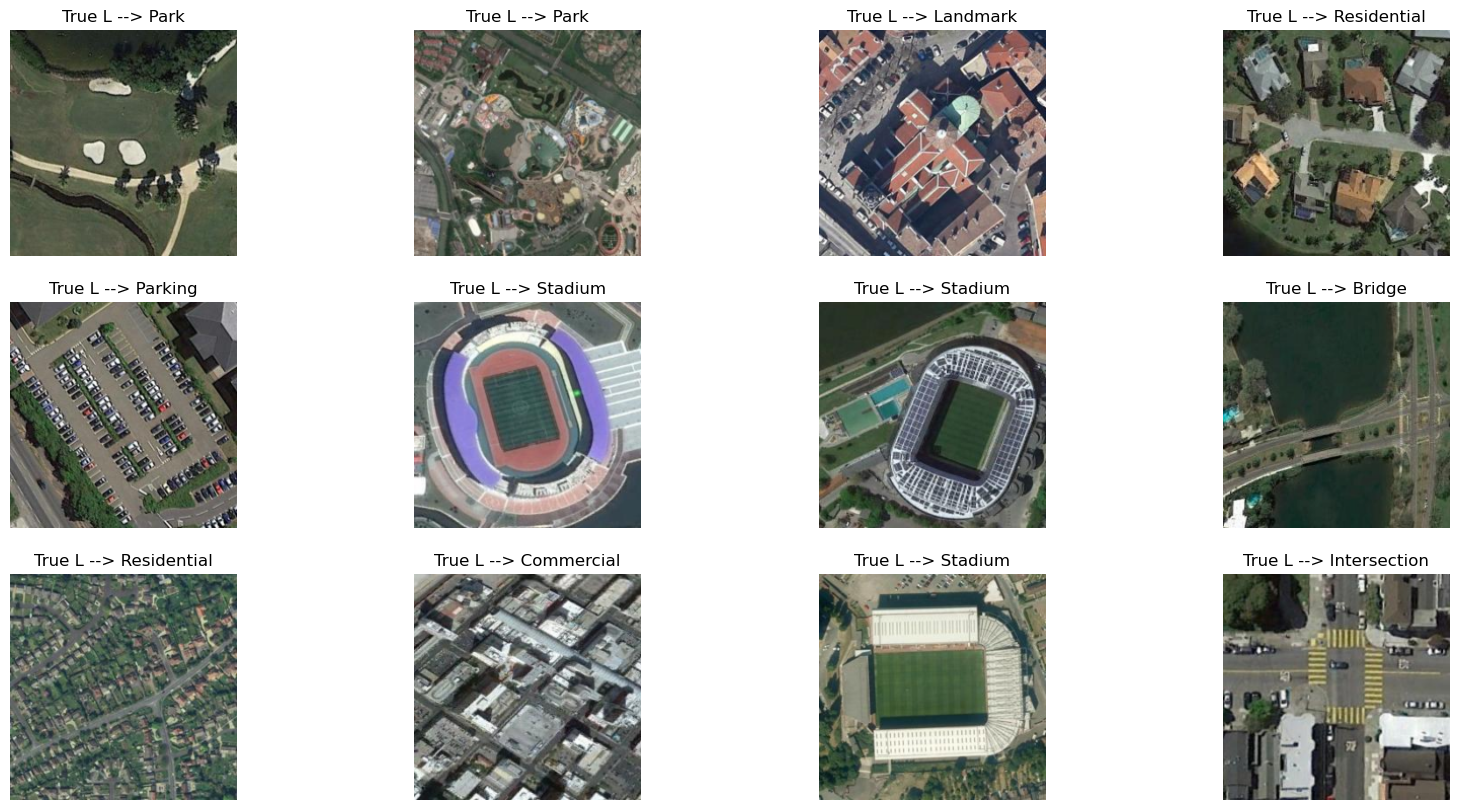

In [28]:
plot_images(tr_dl.dataset, 12, 3, "rgb", list(classes.keys()))